Hi,

This is a demonstration of how powerfull neural networks are!

We're going to generate the spiral database and then try to model this data with softmax and then with a neural network and see how it goes.

We're going to follow this tutorial: http://cs231n.github.io/neural-networks-case-study/
So if you want more info. please access it, it's awesome. But here... we're going to use TensorFlow!

Have fun!

## Generating the data

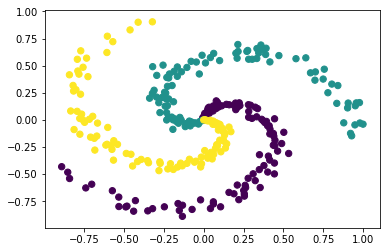

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Exact same code from the tutorial

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

X = np.zeros((N * K, D)) # data matrix (each row = single example)
y = np.zeros(N * K, dtype='uint8') # class labels

for j in xrange(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N) # radius
    t = np.linspace(j * 4,(j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j


# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40)

# Generating a Y with the shape: [None, [0.0, 0.0, 1.0]]
y_ = np.zeros((N * K, K), dtype='uint8')
for i in xrange(N * K):
    for j in xrange(K):
        if j == y[i]:
            y_[i][j] = 1.0

plt.show()

"The toy spiral data consists of three classes (blue, red, yellow) that are not linearly separable."

## Training a Softmax Linear Classifier

In [90]:
# placeholders
input_pl = tf.placeholder(tf.float32, [N * K, D])
labels_pl = tf.placeholder(tf.int32, [N * K, K])

# initialize parameters randomly
W = tf.Variable(tf.truncated_normal([D, K], stddev=0.01), tf.float32)
b = tf.Variable(tf.zeros([1, K]), tf.float32)

# compute class scores for a linear classifier
scores = tf.matmul(input_pl, W) + b
pred = tf.nn.softmax(scores)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_pl,
                                                              logits=scores))

# gradient descent
gd = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

# accuracy
correct_prediction = tf.equal(tf.argmax(labels_pl, 1), tf.argmax(pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()


In [97]:
## Train
w_res = 0
b_res = 0

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in xrange(5000):
        
        _, l, acc = sess.run([gd, loss, accuracy], feed_dict={input_pl: X, labels_pl: y_})
        if i % 100 == 0:
            print 'step: ', i, ', loss: ', l, ', accuracy: ', acc
    
    print 'Done!'
    print 'accuracy:', accuracy.eval({input_pl: X, labels_pl: y_})
    
    
    # saving vars
    w_res = W.eval();
    b_res = b.eval();
    

step:  0 , loss:  1.10166 , accuracy:  0.206667
step:  100 , loss:  0.766809 , accuracy:  0.506667
step:  200 , loss:  0.748459 , accuracy:  0.513333
step:  300 , loss:  0.744918 , accuracy:  0.52
step:  400 , loss:  0.743974 , accuracy:  0.53
step:  500 , loss:  0.743687 , accuracy:  0.53
step:  600 , loss:  0.743595 , accuracy:  0.53
step:  700 , loss:  0.743564 , accuracy:  0.53
step:  800 , loss:  0.743554 , accuracy:  0.53
step:  900 , loss:  0.74355 , accuracy:  0.53
step:  1000 , loss:  0.743549 , accuracy:  0.53
step:  1100 , loss:  0.743548 , accuracy:  0.53
step:  1200 , loss:  0.743548 , accuracy:  0.53
step:  1300 , loss:  0.743548 , accuracy:  0.53
step:  1400 , loss:  0.743548 , accuracy:  0.53
step:  1500 , loss:  0.743548 , accuracy:  0.53
step:  1600 , loss:  0.743548 , accuracy:  0.53
step:  1700 , loss:  0.743548 , accuracy:  0.53
step:  1800 , loss:  0.743548 , accuracy:  0.53
step:  1900 , loss:  0.743548 , accuracy:  0.53
step:  2000 , loss:  0.743548 , accuracy: 

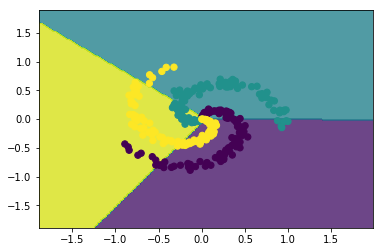

In [111]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_res) + b_res
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
plt.show()

Okay... that was disappointing, a random prediction can get a very close accuracy :/.
Let's see..

## Random approach

In [48]:
# generating a random prediction
r = []
for i in xrange(N * K):
    a = [0.0, 0.0, 0.0]
    a[np.random.randint(3, size=1)[0]] = 1.0
    r.append(a)    
random_pred = tf.constant(r)

# random accuracy
random_correct_prediction = tf.equal(tf.argmax(labels_pl, 1), tf.argmax(random_pred,1))
random_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    
    # print sess.run(random_pred)
    sess.run(init)
    print 'Done!'
    print 'accuracy:', random_accuracy.eval({input_pl: X, labels_pl: y_})

Done!
accuracy: 0.496667


"Clearly, a linear classifier is inadequate for this dataset and we would like to use a Neural Network. One additional hidden layer will suffice for this toy data. We will now need two sets of weights and biases (for the first and second layers):"

## Neural networks show us your power!

In [92]:
h = 100 # size of hidden layer

In [93]:
# placeholders
input_pl2 = tf.placeholder(tf.float32, [N * K, D])
labels_pl2 = tf.placeholder(tf.int32, [N * K, K])

# initialize parameters randomly
# first layer
W1 = tf.Variable(tf.truncated_normal([D, h], stddev=0.01), tf.float32)
b1 = tf.Variable(tf.zeros([1, h]), tf.float32)

# evaluate class scores with a 2-layer Neural Network
hidden_layer = tf.nn.relu(tf.matmul(input_pl2, W1) + b1) # note, ReLU activation

# second (and last, wow that is a small network)layer
W2 = tf.Variable(tf.truncated_normal([h, K], stddev=0.01), tf.float32)
b2 = tf.Variable(tf.zeros([1, K]), tf.float32)
scores = tf.matmul(hidden_layer, W2) + b2
pred = tf.nn.softmax(scores)

# loss
loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_pl2,
                                                               logits=scores))
# gradient descent
gd2 = tf.train.GradientDescentOptimizer(0.5).minimize(loss2)

# accuracy
correct_prediction = tf.equal(tf.argmax(labels_pl2, 1), tf.argmax(pred,1))
accuracy2 = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init2 = tf.global_variables_initializer()

In [104]:
## Train
w1_res = 0
b1_res = 0
w2_res = 0
b2_res = 0

with tf.Session() as sess:
    
    sess.run(init2)
    
    for i in xrange(5000):
        
        _, l, acc = sess.run([gd2, loss2, accuracy2], feed_dict={input_pl2: X, labels_pl2: y_})
        if i % 100 == 0:
            print 'step: ', i, ', loss: ', l, ', accuracy: ', acc
    
    print 'Done!'
    print 'accuracy:', accuracy2.eval({input_pl2: X, labels_pl2: y_})
    
    w1_res, b1_res, w2_res, b2_res = W1.eval(), b1.eval(), W2.eval(), b2.eval()

step:  0 , loss:  1.09866 , accuracy:  0.263333
step:  100 , loss:  0.723835 , accuracy:  0.563333
step:  200 , loss:  0.68475 , accuracy:  0.6
step:  300 , loss:  0.663375 , accuracy:  0.613333
step:  400 , loss:  0.629539 , accuracy:  0.636667
step:  500 , loss:  0.572051 , accuracy:  0.67
step:  600 , loss:  0.573224 , accuracy:  0.713333
step:  700 , loss:  0.539408 , accuracy:  0.77
step:  800 , loss:  0.438677 , accuracy:  0.82
step:  900 , loss:  0.361611 , accuracy:  0.853333
step:  1000 , loss:  0.313211 , accuracy:  0.863333
step:  1100 , loss:  0.270861 , accuracy:  0.89
step:  1200 , loss:  0.239309 , accuracy:  0.893333
step:  1300 , loss:  0.214116 , accuracy:  0.903333
step:  1400 , loss:  0.193004 , accuracy:  0.91
step:  1500 , loss:  0.17253 , accuracy:  0.933333
step:  1600 , loss:  0.158514 , accuracy:  0.936667
step:  1700 , loss:  0.14407 , accuracy:  0.95
step:  1800 , loss:  0.132705 , accuracy:  0.956667
step:  1900 , loss:  0.124079 , accuracy:  0.956667
step:

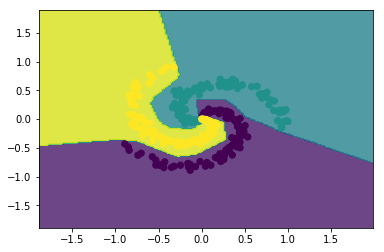

In [110]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1_res) + b1_res), w2_res) + b2_res
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
plt.show()

### WOW that's a ~cool~ accuracy and a ~cool~ graph, you rock!